<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial

In this notebook, we illustrate how to simulate seabird foraging trajectories using Deep Convolutional Generative Adversarial Networks [(DCGAN)](https://arxiv.org/pdf/1511.06434.pdf%C3)

## 1. Data exploration

### (a) import dataset

In [ ]:
import pandas as pd

# import csv file from my github repository
url = 'https://raw.githubusercontent.com/AmedeeRoy/BirdGAN/master/data/trips_SV_200_steps.csv'
data = pd.read_csv(url)
data.head()

,trip,lon,lat,dive,datetime
0,P1108_12_SV_T1,-77.268339,-11.777933,0.184634,2008-11-29 19:51:00
1,P1108_12_SV_T1,-77.272344,-11.781284,0.031351,2008-11-29 19:52:00
2,P1108_12_SV_T1,-77.274705,-11.785334,0.010592,2008-11-29 19:53:00
3,P1108_12_SV_T1,-77.276275,-11.790922,0.108032,2008-11-29 19:54:00
4,P1108_12_SV_T1,-77.277807,-11.794704,0.616333,2008-11-29 19:55:00


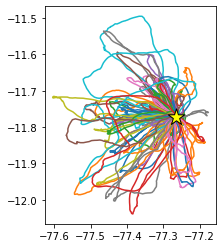

In [ ]:
import matplotlib.pyplot as plt

colony = (-77.264, -11.773)

# quick plot of the data
for t in data.trip.unique():
  plt.plot(data.lon[data.trip == t], data.lat[data.trip == t], zorder = 1)
plt.scatter(colony[0], colony[1], marker = '*', color = 'yellow', edgecolors = 'black', s = 300, zorder = 2)
plt.gca().set_aspect(1)

### (b) format data

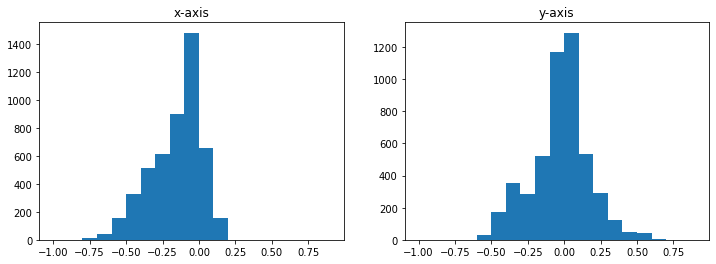

In [ ]:
import numpy as np

# projection of coordinates in meters
R = 6377726 # earth radius
data['x'] = np.pi * R * (data['lon'] - colony[0])/180
data['y'] = np.pi * R * (data['lat'] - colony[1])/180

# standardization of (x,y) coordinates
scale = 5e4 # empirical choice
data['x_std'] = data['x']/scale
data['y_std'] = data['y']/scale

plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.hist(data.x_std, bins = np.arange(-1,1,0.1))
plt.title('x-axis')
plt.subplot(1,2,2)
plt.hist(data.y_std, bins = np.arange(-1,1,0.1))
plt.title('y-axis')
plt.show()

In [ ]:
# padding all trajectories with zeros in a big matrix

padding = 200
traj_all = np.zeros((len(data.trip.unique()), 2, padding))

i = 0
for tt in data.trip.unique():
    traj = data[data.trip == tt].copy()
    traj = traj.loc[:,('x_std', 'y_std')].to_numpy()
    
    n = traj.shape[0]
    traj_all[i, :, 1:n+1] = traj.T
    i += 1

### (c) create dataloader

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

In [ ]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [ ]:
# hyperparameters
batch_size = 32

## reduce size dataset
train_set = TrajDataSet(traj_all, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [ ]:
x =  next(iter(train_loader))
x = x.cpu().numpy()

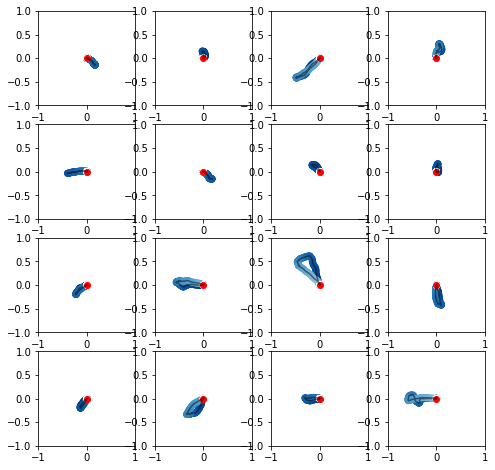

In [ ]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(x[i,0,:], x[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x[i,0,:], x[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

## 2. GAN Training

In [ ]:
from torch import nn
from torch import optim
import progressbar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
    def forward(self, z):    
        out = self.cnn(z)
        return out


class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)



def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# create network
generator = CNNGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

# weight initialization
generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

# define loss and optimizers
criterion = nn.BCELoss()
lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

  9% (49 of 500) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:34


Epoch [51/500] -----------------------------------------------------------------------------


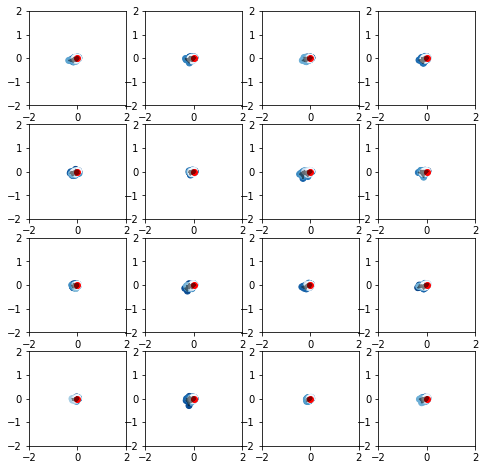

 19% (99 of 500) |####                   | Elapsed Time: 0:00:23 ETA:   0:01:27


Epoch [101/500] -----------------------------------------------------------------------------


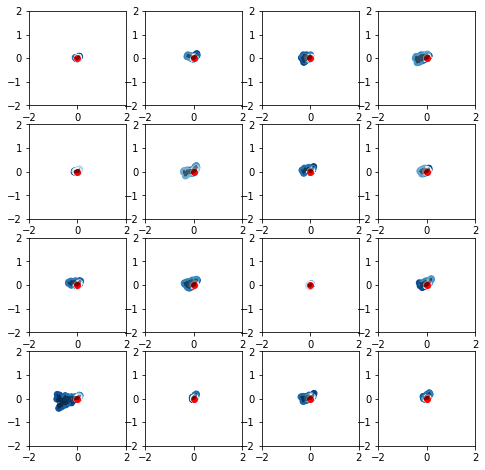

 29% (149 of 500) |######                | Elapsed Time: 0:00:35 ETA:   0:01:15


Epoch [151/500] -----------------------------------------------------------------------------


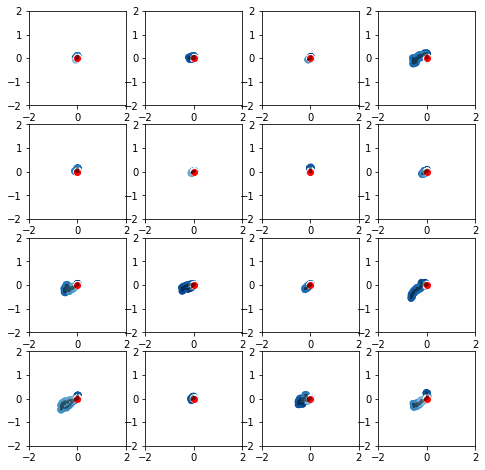

 39% (199 of 500) |########              | Elapsed Time: 0:00:47 ETA:   0:01:03


Epoch [201/500] -----------------------------------------------------------------------------


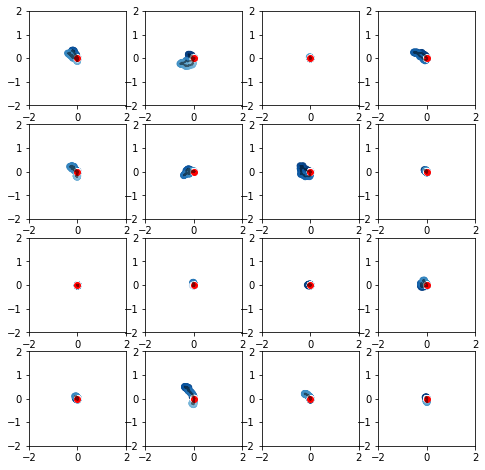

 49% (249 of 500) |##########            | Elapsed Time: 0:01:00 ETA:   0:00:54


Epoch [251/500] -----------------------------------------------------------------------------


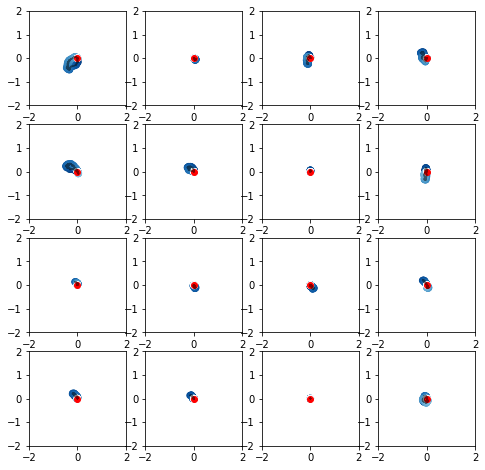

 59% (299 of 500) |#############         | Elapsed Time: 0:01:12 ETA:   0:00:43


Epoch [301/500] -----------------------------------------------------------------------------


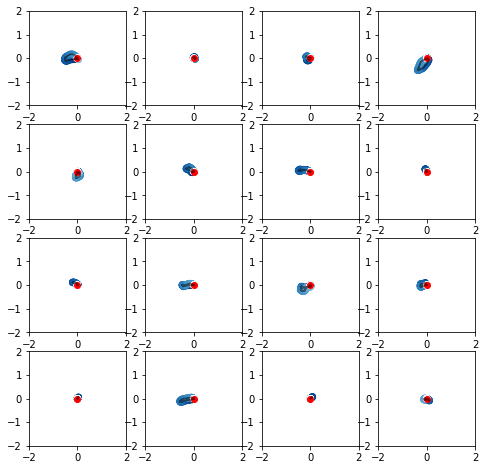

 69% (349 of 500) |###############       | Elapsed Time: 0:01:25 ETA:   0:00:31


Epoch [351/500] -----------------------------------------------------------------------------


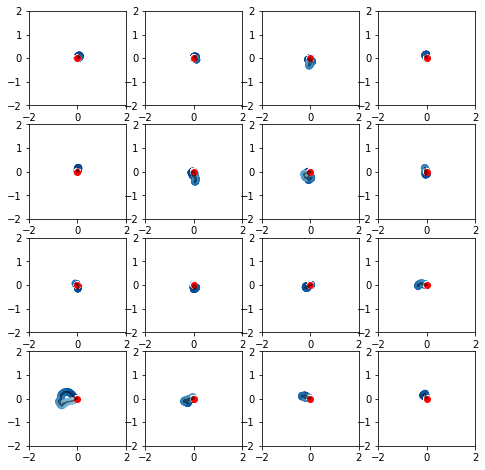

 79% (399 of 500) |#################     | Elapsed Time: 0:01:37 ETA:   0:00:21


Epoch [401/500] -----------------------------------------------------------------------------


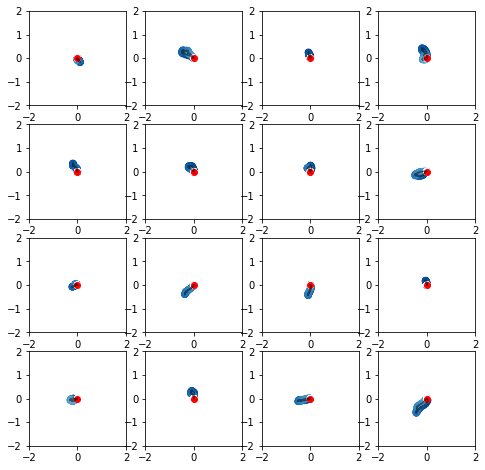

 89% (449 of 500) |###################   | Elapsed Time: 0:01:49 ETA:   0:00:11


Epoch [451/500] -----------------------------------------------------------------------------


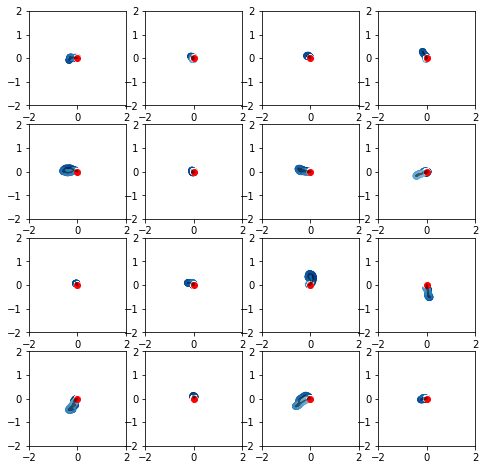

 99% (499 of 500) |##################### | Elapsed Time: 0:02:02 ETA:   0:00:00


Epoch [501/500] -----------------------------------------------------------------------------


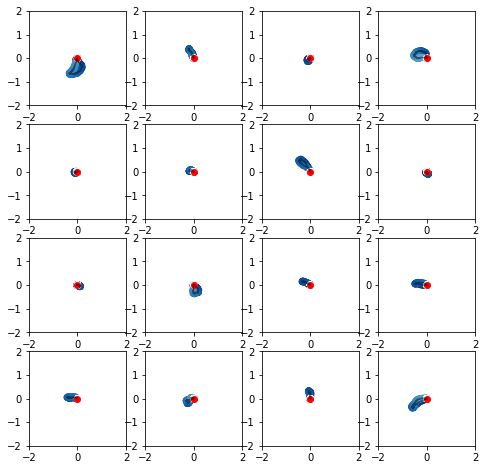

100% (500 of 500) |######################| Elapsed Time: 0:02:04 Time:  0:02:04


In [ ]:
# Train the model
nb_epoch = 500

epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones)
        loss.backward()
        optim_g.step()

    if epoch%50 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()


 19% (99 of 500) |####                   | Elapsed Time: 0:00:21 ETA:   0:01:26


Epoch [101/500] -----------------------------------------------------------------------------


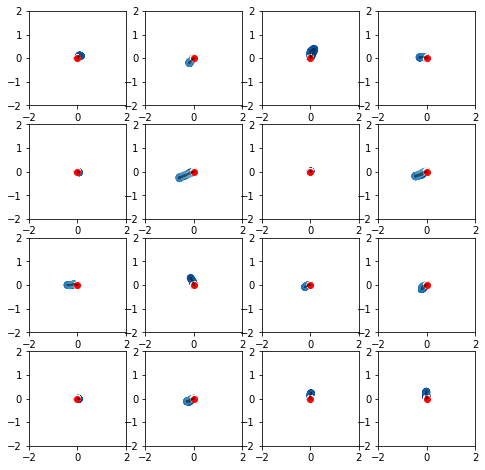

 39% (199 of 500) |########              | Elapsed Time: 0:00:44 ETA:   0:01:04


Epoch [201/500] -----------------------------------------------------------------------------


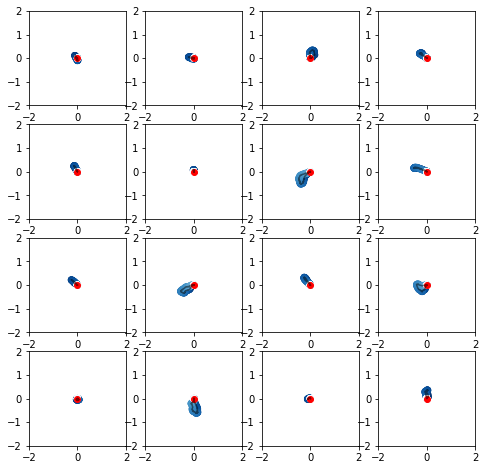

 59% (299 of 500) |#############         | Elapsed Time: 0:01:07 ETA:   0:00:42


Epoch [301/500] -----------------------------------------------------------------------------


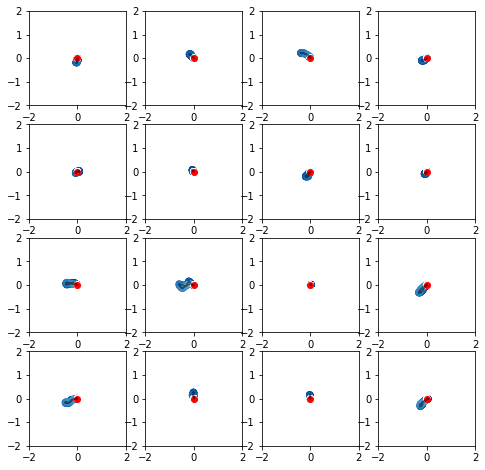

 79% (399 of 500) |#################     | Elapsed Time: 0:01:31 ETA:   0:00:22


Epoch [401/500] -----------------------------------------------------------------------------


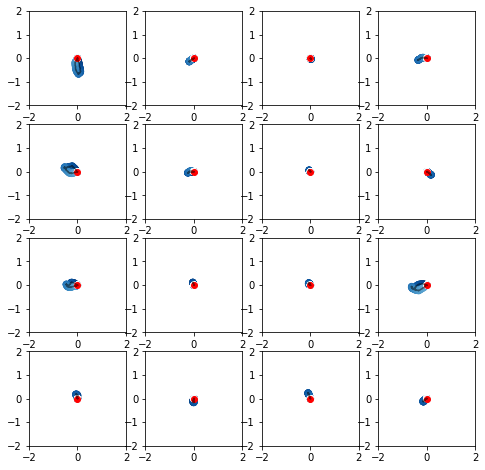

 99% (499 of 500) |##################### | Elapsed Time: 0:01:54 ETA:   0:00:00


Epoch [501/500] -----------------------------------------------------------------------------


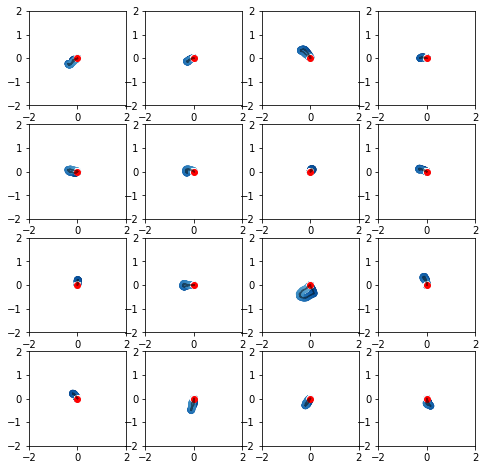

100% (500 of 500) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


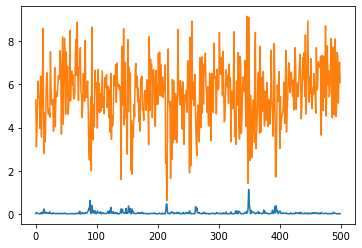

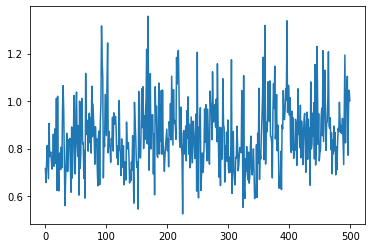

In [ ]:
# Train the model with periodogram
nb_epoch = 500

lamda = 50.0

lossd = []
lossg = []
dp = []


epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)

        # loss_w = - discriminator(x) + discriminator(fake_samples) # remplace loss1
        
        # combine
        loss1 = (loss_real + loss_fake) / 2
        loss1.backward()
        optim_d.step()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)
        

        generated = generator(z) # bruit à travers generateur -> echantillons

        pf = periodogram(generated) 
        pt = periodogram(x)
        dpft = ((pf - pt)**2).mean()

        classifications = discriminator(generated)
        loss2 = criterion(classifications, target_ones) #+ lamda * dpft
        # avec loss_w / remplace loss2
        # lossg = - discriminator(generated)
        loss2.backward() # calcul gradient par rapport a la loss
        optim_g.step()

        ## avec loss_w -> normalisation spectrale

    lossd.append(loss1.item())
    lossg.append(loss2.item())
    dp.append(dpft.item())


    if epoch%100 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch))  
        
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

plt.plot(range(nb_epoch),lossd)
plt.plot(range(nb_epoch),lossg)
plt.show()
plt.close()

plt.plot(range(nb_epoch),dp)
plt.show()
plt.close()

## 3. GAN performance evaluation

In [ ]:
# generate synthetic trajectories
nb = 100
z = torch.randn((nb, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)

traj_sim = generated.cpu().detach().numpy()

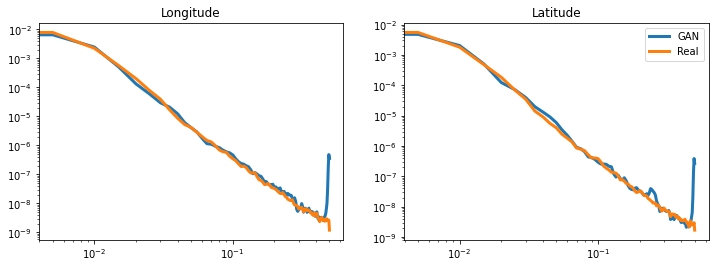

In [ ]:
# Fourier spectral density
import scipy.signal as sp

def get_periodogram(traj):
    periodogram_lon = []
    periodogram_lat = []

    for j in range(traj.shape[0]):
        lon = traj[j, 0, :]
        lat = traj[j, 1, :]
        x, lon = sp.periodogram(lon, scaling = 'spectrum', detrend = False)
        x, lat = sp.periodogram(lat, scaling = 'spectrum', detrend = False)

        periodogram_lon.append(lon)
        periodogram_lat.append(lat)

    return (x, np.mean(periodogram_lon, axis=0), np.mean(periodogram_lat, axis=0))


(x, lon_all, lat_all) = get_periodogram(traj_all)
(x, lon_sim, lat_sim) = get_periodogram(traj_sim)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.loglog(x, lon_sim, linewidth = 3, label = 'GAN', color ='tab:blue')
plt.loglog(x, lon_all, linewidth = 3, label = 'Real', color='tab:orange')
plt.title('Longitude')
plt.subplot(1,2,2)
plt.loglog(x, lat_sim, linewidth = 3, label = 'GAN', color ='tab:blue')
plt.loglog(x, lat_all, linewidth = 3, label = 'Real', color='tab:orange')
plt.title('Latitude')
plt.legend()
plt.show()

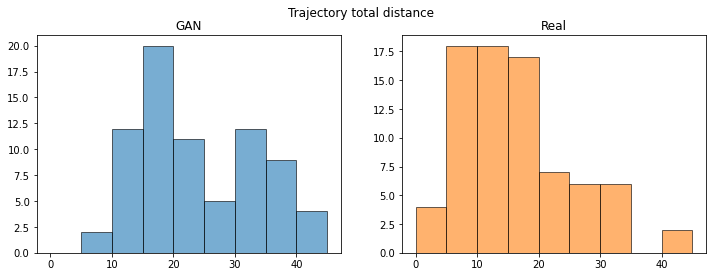

In [ ]:
## Compare trajectories total distance

def coord2step(coord):
  step = np.sqrt(np.diff(coord[:,0,:])**2 + np.diff(coord[:,1,:])**2)
  step = np.append(np.zeros((coord.shape[0],1)), step, 1)
  direction = np.diff(np.arctan2(np.diff(coord[:,1,:]),np.diff(coord[:,0,:])))
  direction = np.append(np.zeros((coord.shape[0],2)), direction, 1)
  return np.stack([step*20, direction/2/np.pi], 1)

step_sim = coord2step(traj_sim)
step_all = coord2step(traj_all)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(np.sum(step_sim[:,0,:], 1), bins = np.arange(0, 50, 5), alpha = 0.6, color='tab:blue', edgecolor = 'black')
plt.title('GAN')
plt.subplot(1,2,2)
plt.hist(np.sum(step_all[:,0,:], 1), bins = np.arange(0, 50, 5), alpha = 0.6, color='tab:orange', edgecolor = 'black')
plt.title('Real')
plt.suptitle('Trajectory total distance')
plt.show()


In [ ]:
def periodogram(tt):
   periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
   return torch.log(periodogram)

z = torch.randn((78, 256, 1), device=device)
with torch.no_grad():
  fake_samples = generator(z)

print(traj_all.shape)


(78, 2, 200)


In [ ]:
pf = periodogram(fake_samples)

pt = periodogram(torch.tensor(traj_all))

dpft = ((pf - pt)**2).mean()

print(dpft.item())

0.9748811100644516


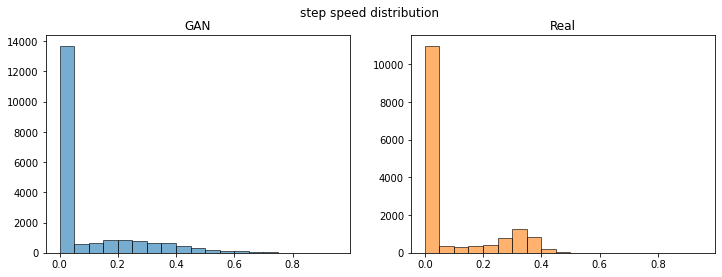

In [ ]:
## Compare trajectories step distribution

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(step_sim[:,0,:].flatten(), bins = np.arange(0, 1, 0.05), alpha = 0.6, color='tab:blue', edgecolor = 'black')
plt.title('GAN')
plt.subplot(1,2,2)
plt.hist(step_all[:,0,:].flatten(), bins = np.arange(0, 1, 0.05), alpha = 0.6, color='tab:orange', edgecolor = 'black')
plt.title('Real')
plt.suptitle('step speed distribution')
plt.show()




---


DCGAN applied to seabird trajectories simulation are particularly relevant for capturing large-scale feature (e.g. trajectory total distance) however they fail to capture small-scale features (e.g. step speed distribution). This result is also illustrated by comparing Fourier density spectrum of Longitude and Latitude for real trajectories and synthetic ones.


---





# Ideas for improvement



### (a) Add layer to network for refining local scale

In [ ]:
# class CNNGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.cnn = nn.Sequential(    
#             nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
#             nn.BatchNorm1d(128),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(32),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(32, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(16),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(16, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(8),
#             nn.ReLU(True),

#             nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.ReLU(True),
#             nn.Conv1d(8, 2, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.Tanh()
#          )
#     def forward(self, z):    
#         out = self.cnn(z)
#         return out


# class CNNDiscriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
                
#         self.cnn = nn.Sequential(
#             nn.Conv1d(2, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),
#             nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(8, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         out = self.cnn(x)
#         return out.squeeze(1)

### (b) Add a spectral loss

In [ ]:
# # function for spectral loss
# def periodogram(tt):
#   periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
#   return torch.log(periodogram)

### (c) Add a step distribution density loss

In [ ]:
# def differentiable_histogram(x, bins=255, min=0.0, max=1.0):

#     if len(x.shape) == 4:
#         n_samples, n_chns, _, _ = x.shape
#     elif len(x.shape) == 2:
#         n_samples, n_chns = 1, 1
#     else:
#         raise AssertionError('The dimension of input tensor should be 2 or 4.')

#     hist_torch = torch.zeros(n_samples, n_chns, bins).to(x.device)
#     delta = (max - min) / bins

#     BIN_Table = torch.arange(start=0, end=bins, step=1) * delta

#     for dim in range(1, bins-1, 1):
#         h_r = BIN_Table[dim].item()             # h_r
#         h_r_sub_1 = BIN_Table[dim - 1].item()   # h_(r-1)
#         h_r_plus_1 = BIN_Table[dim + 1].item()  # h_(r+1)

#         mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
#         mask_plus = ((h_r_plus_1 > x) & (x >= h_r)).float()

#         hist_torch[:, :, dim] += torch.sum(((x - h_r_sub_1) * mask_sub).view(n_samples, n_chns, -1), dim=-1)
#         hist_torch[:, :, dim] += torch.sum(((h_r_plus_1 - x) * mask_plus).view(n_samples, n_chns, -1), dim=-1)

#     return hist_torch / delta